In [1]:
# Imports
#%matplotlib qt
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import os
import numpy as np
from scipy.stats import pearsonr
from matplotlib import cm
import scipy
import sys
from collections import Counter

from fooof import FOOOF
from fooof import FOOOFGroup

In [2]:
fg = FOOOFGroup()

In [3]:
# Set up paths

# This base path will need updating
base_path = 'D:\\abc\\Documents\\Research\\rtPB_Data'

# These should stay the same
#subj_dat_fname = '._35**_resampled.set'
subj_dat_fname = '3512_resampled.set'

In [4]:
ev_dict = {
    # Recording Blocks
    'Filt Labelling': 1000,
    'Thresh Labelling Block': 1001,
    
    # Instruction Blocks
    'Start Labelling Block':2000,
    'End Labelling Block': 2001,
    
    # Rest Blocks 
    'Start Block':3000,
    'End Block':3001,
    
    # Trial Markers
    'Label_Peak_filt': 4000,
    'Label_Trough_filt':4001,
    'Markers0':4002,
    'Markers1' :4002,
    'MissTrial':4003,
    'HitTrial':4004
}


In [5]:
# Read in subject listed above
full_path = os.path.join(base_path, subj_dat_fname)
eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)

Events like the following will be dropped entirely: ['Label_Trough_filt', 'Trough_Pres_filt', 'Label_Rise_filt', 'Filt Labelling', 'SPACE released'], 41 in total
Events like the following will be dropped, but could be reduced to their integer part instead with the default `event_id_func`: ['NUMPAD5 pressed', 'Markers1', 'NUMPAD0 pressed', 'Markers0.0', 'NUMPAD1 pressed'], 12 in total
3178/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
As is, the trigger channel will consist entirely of zeros.
Reading D:\abc\Documents\Research\rtPB_Data\3512_resampled.fdt
Reading 0 ... 1750854  =      0.000 ...  3501.708 secs...


<ipython-input-5-d91f2579a730>:3: RuntimeWarning: Events like the following will be dropped entirely: ['Label_Trough_filt', 'Trough_Pres_filt', 'Label_Rise_filt', 'Filt Labelling', 'SPACE released'], 41 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)
<ipython-input-5-d91f2579a730>:3: RuntimeWarning: Events like the following will be dropped, but could be reduced to their integer part instead with the default `event_id_func`: ['NUMPAD5 pressed', 'Markers1', 'NUMPAD0 pressed', 'Markers0.0', 'NUMPAD1 pressed'], 12 in total
  eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)
<ipython-input-5-d91f2579a730>:3: RuntimeWarning: 3178/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  eeg_dat = mne.io.read_raw_eeglab(full_path, event_id_func=None, preload=True)
<ipython-input-5-d91f2579a730>:3: RuntimeWarning: As is, the trigger channel will consist entirely of zeros.
 

In [6]:
evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)

Events like the following will be dropped entirely: ['Trough_Pres_filt', 'Label_Rise_filt', 'SPACE released', 'Sham_Pres_catch', 'Peak_Pres_filt'], 32 in total
1706/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.


<ipython-input-6-e55b000d48b3>:1: RuntimeWarning: Events like the following will be dropped entirely: ['Trough_Pres_filt', 'Label_Rise_filt', 'SPACE released', 'Sham_Pres_catch', 'Peak_Pres_filt'], 32 in total
  evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)
<ipython-input-6-e55b000d48b3>:1: RuntimeWarning: 1706/3178 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
  evs = mne.io.eeglab.read_events_eeglab(full_path, ev_dict)


In [7]:
new_evs = np.empty(shape=(0, 3))
#for ev_code in [2000, 3000]:
for ev_label in ['Start Labelling Block', 'Start Block']:
    ev_code = ev_dict[ev_label]
    temp = evs[evs[:, 2] == ev_code]
    new_evs = np.vstack([new_evs, temp])

In [8]:
Counter(evs[:, 2])
#new_evs
# Sanity check
# evs[evs[:, 2] == 5000]

Counter({0: 242,
         1: 2,
         5: 2,
         7: 2,
         10: 240,
         1000: 1,
         2000: 2,
         2001: 2,
         3000: 10,
         3001: 10,
         4000: 26,
         4001: 21,
         4002: 216,
         4003: 323,
         4004: 373})

In [9]:
eeg_dat.add_events(new_evs)

In [10]:
Counter(eeg_dat._data[-1, :])

Counter({0.0: 1750843, 2000.0: 2, 3000.0: 10})

In [11]:
eeg_dat.set_eeg_reference()
# set EEG average reference

The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<ipython-input-11-be3e7d7f3762>:1: DeprecationWarning: The behavior of set_eeg_reference will change in 0.16 when ref_channels="average". Currently, a projection is computed, which has to be applied manually with the apply_proj method. In 0.16, the average reference will be directly applied. Set projection=True if you want to retain the old behavior, or set projection=False if you want the new behavior.
  eeg_dat.set_eeg_reference()


<RawEEGLAB  |  3512_resampled.fdt, n_channels x n_times : 65 x 1750855 (3501.7 sec), ~868.4 MB, data loaded>

In [12]:
# identifying all the events and IDs
mne.find_events(eeg_dat);

12 events found
Events id: [2000 3000]


In [13]:
events = mne.find_events(eeg_dat)
event_id = {'Start Labelling Block':2000, 'Start Block': 3000}
epochs = mne.Epochs(eeg_dat, events=events, event_id=event_id)

12 events found
Events id: [2000 3000]
12 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


Loading data for 12 events and 351 original time points ...
0 bad epochs dropped
Loading data for 12 events and 351 original time points ...


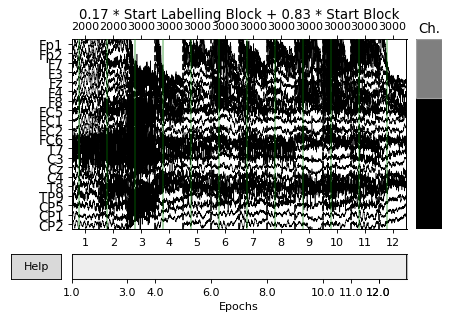

In [24]:
epochs.plot();

# Marking bad channels
### Based on visualization.


In [12]:
eeg_dat.info['bads'] = ['TP9']

In [13]:
print('Bad channels: ', eeg_dat.info['bads'])

Bad channels:  ['TP9']


12 events found
Events id: [2000 3000]
Found %s events.



C:\Users\abc\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


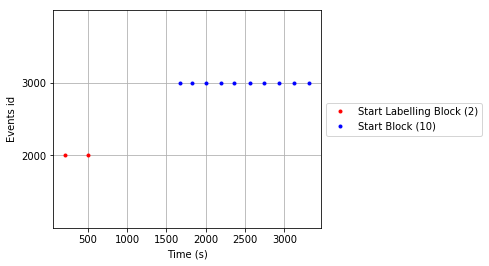

In [25]:
events = mne.find_events(eeg_dat)
print('Found %s events.')
print()

# Plot the events to get an idea of the paradigm
# Specify colors and an event_id dictionary for the legend.
# Plotting only Start and Rest Block events
event_id = {'Start Labelling Block':2000, 'Start Block': 3000}
color = {2000:'red', 3000:'blue'}

mne.viz.plot_events(events, eeg_dat.info['sfreq'], eeg_dat.first_samp, color=color,
                    event_id=event_id);

# Marking bad moments
### Identifying bad moments based on visualization

In [15]:
# Not to critical for this data

In [16]:
epochs = mne.Epochs(eeg_dat, events=events, event_id=event_id, tmin = 5, tmax = 125,
                    baseline = None)

10 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [18]:
chs = mne.channels.read_montage('standard_1020', epochs.ch_names[:-1])
epochs.set_montage(chs)

<Epochs  |  n_events : 10 (good & bad), tmin : 5.0 (s), tmax : 125.0 (s), baseline : None, ~169 kB, data not loaded,
 'Start Block': 8, 'Start Labelling Block': 2>

In [19]:
epochs.drop_bad()

Loading data for 10 events and 60001 original time points ...
0 bad epochs dropped


<Epochs  |  n_events : 10 (all good), tmin : 5.0 (s), tmax : 125.0 (s), baseline : None, ~169 kB, data not loaded,
 'Start Block': 8, 'Start Labelling Block': 2>

Loading data for 10 events and 60001 original time points ...


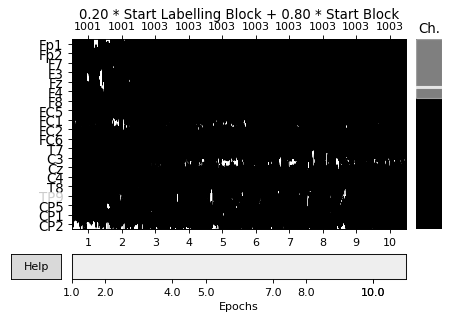

In [20]:
epochs.plot();

In [35]:
epochs.events.tolist()

[[109701, 0, 1001],
 [250205, 0, 1001],
 [834020, 0, 1003],
 [913823, 0, 1003],
 [1003103, 0, 1003],
 [1096352, 0, 1003],
 [1179632, 0, 1003],
 [1372366, 0, 1003],
 [1467821, 0, 1003],
 [1656105, 0, 1003]]

In [22]:
# Calculate PSDs
psds, freqs = mne.time_frequency.psd_welch(epochs, fmin=1., fmax=50., n_fft=2000, n_overlap=250, n_per_seg=500)

# Average PSDs for each channel across each rest block
#avg_psds = np.mean(psds, axis=0)

Loading data for 10 events and 60001 original time points ...
Effective window size : 4.000 (s)


In [23]:
# Get freq res of PSD
f_res = np.mean(np.diff(freqs))

In [28]:
psds.shape

(10, 63, 197)

In [ ]:
for i, j in psds.i

In [32]:
for ind, entry in enumerate(psds):
    print(entry.shape)

(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)
(63, 197)


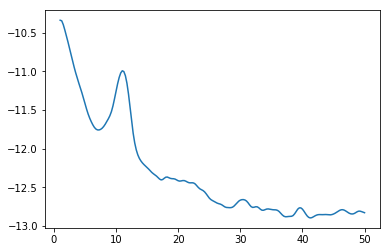

In [26]:
plt.plot(freqs, np.log10(psds[4, 30, :]))
# The 1st PSD

In [ ]:
plt.plot(freqs, np.log10(psds[1, 30, :]))
# The 2nd PSD

# FOOOFing Data

In [27]:
fooof_psds = np.squeeze(psds[4,:,:])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 32 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -11.1002, 1.0722                                         
                                                                                                  
                                       4 peaks were found:                                        
          

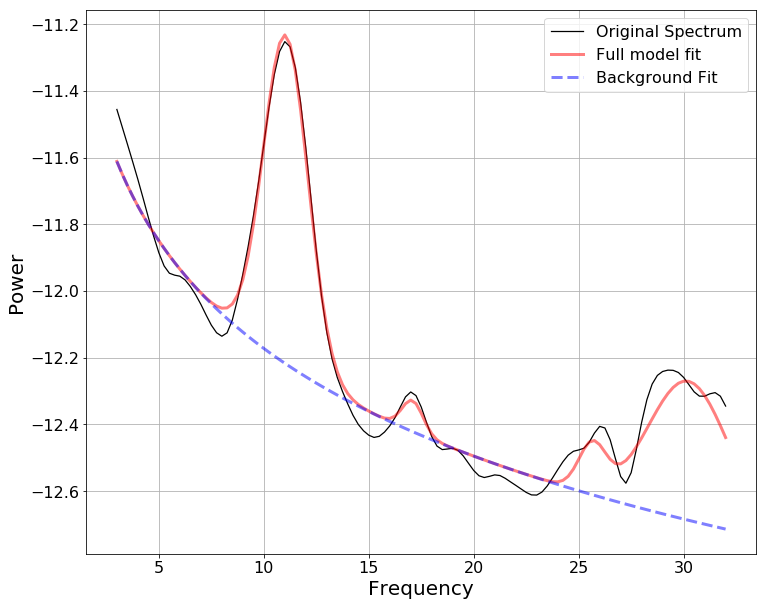

In [28]:
# Initialzing FOOOF model
fm = FOOOF(peak_width_limits=[1, 6], min_peak_amplitude=0.075, max_n_peaks=6, peak_threshold=1)

# Setting frequency range
freq_range = [3, 32]

fm.report(freqs, fooof_psds[40, :], freq_range)

In [205]:
# Run FOOOF across a group of PSDs
fg = FOOOFGroup(verbose=False)
fg.fit(freqs, fooof_psds, freq_range)

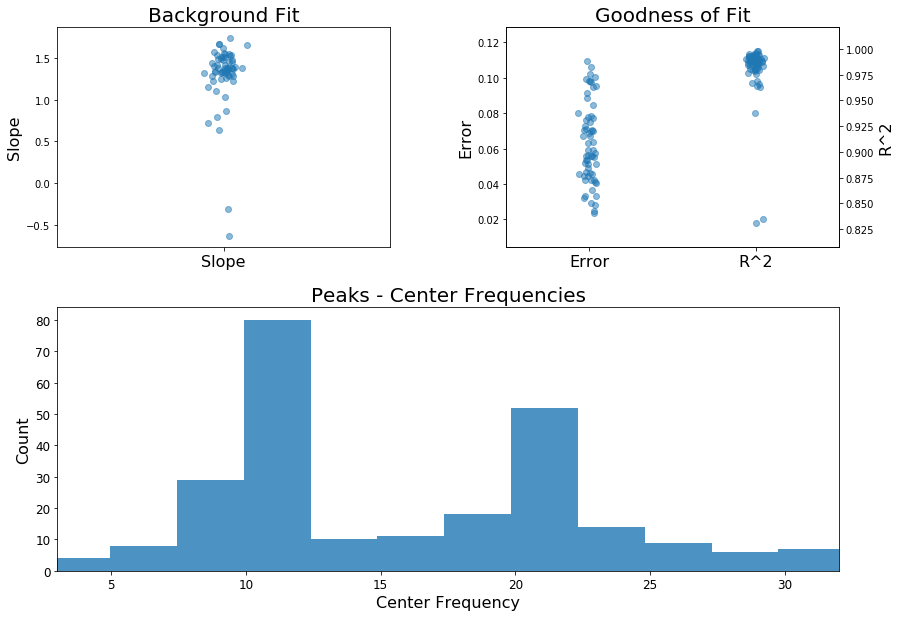

In [206]:
fg.plot()

In [ ]:
n_channels, n_freq = fooof_psds.shape

In [ ]:
fooof_results = np.zeros(shape = [n_channels,3])

In [ ]:
for i, ch_dat in enumerate(fg.group_results):
    fooof_results[i,:] = get_band_osc(ch_dat.oscillations_params, [8, 12])

In [ ]:
cfs = fooof_results[:, 0]
amps = fooof_results[:, 1]
bws = fooof_results[:,2]

In [ ]:
cfs = np.nan_to_num(cfs)
amps = np.nan_to_num(amps)
bws = np.nan_to_num(bws)

In [ ]:
# Define our oscillation bands
bands = [['Theta', [4, 8]], ['Alpha', [8, 12]]]

In [ ]:
# DESIRED OUTPUT:
#  1d array, len of n_channels with osc_band freq for each channel
#  Note: deal with the band in channel: try out different markers for none (0, nan, etc.)

# Mapping

In [ ]:
montage = mne.channels.read_montage('standard_1020', epochs.ch_names[:-1])
epochs.set_montage(montage)

In [ ]:
mne.viz.plot_topomap(cfs, epochs.info, cmap=cm.viridis, contours=0);

In [ ]:
mne.viz.plot_topomap(amps, epochs.info, cmap=cm.viridis, contours=0);

In [ ]:
mne.viz.plot_topomap(bws, epochs.info, cmap=cm.viridis, contours=0);